##### Copyright 2024 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

# Data Preparation

#### Step 1: Get the Embeddings: The following cells in this notebook will access the PD-Foundations embeddings directly from a BigQuery table.

⚠️ Important: To run these cells successfully, you must first obtain access to the embeddings dataset via a BigQuery Listing. Please use [this form](https://forms.gle/ysdp5uUoPrMrhjZQA) to apply for research access or to join the Early Access Program waitlist.

Once your access is approved, ensure you are authenticated in this Colab with a Google account that has permission to query the BigQuery table...

In [1]:
PROJECT_ID = '<pdfm_project_id>' # @param {type:"string"}


In [18]:
import pandas as pd


# @markdown Specify the BigQuery table ID for the embeddings.
# Example: 'your-gcp-project.your_dataset.your_table'
bigquery_table_id = '<pdfm_project_id>.pdfm_embeddings.us_embeddings_county_v0' # @param {type:"string"}

# Construct the SQL query.
# This query selects all columns from the specified BigQuery table.
# Ensure your BigQuery table has a column named 'place' to be used as the index.
query = f"SELECT * FROM `{bigquery_table_id}`"

# Load data from BigQuery into a pandas DataFrame.
# pd.read_gbq handles authentication using your Colab credentials.
county_embeddings = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard').set_index('place_name')

/tmp/ipython-input-240918670.py:15: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  county_embeddings = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard').set_index('place_name')


In [19]:
county_embeddings['state'] = county_embeddings['location_metadata'].apply(lambda x: x.get('administrative_area_level1'))
county_embeddings['county'] = county_embeddings['location_metadata'].apply(lambda x: x.get('administrative_area_level2'))

In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
embedding_features = [f'feature{x}' for x in range(330)]
county_embeddings.head(2)

,region_type,features,location_metadata,state,county
place_name,,,,,
geoId/01001,county,"[-0.05920428, 1.1538337, 0.28674558, 0.3241784...","{'latitude': 32.5322367, 'administrative_area_...",Alabama,Autauga County
geoId/01003,county,"[-0.08929817, 0.71066606, 0.35845345, 1.138982...","{'latitude': 30.6592183, 'administrative_area_...",Alabama,Baldwin County


#### Step 2: Download and prepare monthly unemployment data at county level from Data Commons

In [6]:
!pip install datacommons_pandas --upgrade --quiet
import datacommons_pandas as dc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.5 MB/s eta 0:00:00


In [22]:
label = 'UnemploymentRate_Person'
# Due to response size limits, we'll query in batches.
batch_size = 200

all_labels = []
for start in range(0, county_embeddings.index.shape[0], batch_size):
    batch_indices = county_embeddings.index[start : start + batch_size]
    batch_data = dc.build_time_series_dataframe(batch_indices, label)
    all_labels.append(batch_data)

df_labels = pd.concat(all_labels)

print(df_labels.shape)
df_labels.head(2)

(3088, 433)


,1990-01,1990-02,1990-03,1990-04,1990-05,1990-06,1990-07,1990-08,1990-09,1990-10,...,2025-04,2025-05,2025-06,2025-07,2025-08,2014,2016,2018,2020,2022
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,6.5,6.4,5.6,6.6,6.1,7.2,6.0,6.8,7.3,7.3,...,2.3,2.4,2.6,2.4,2.2,NaN,NaN,NaN,NaN,NaN
geoId/01003,6.4,6.0,5.2,4.9,4.3,4.8,4.9,4.9,5.4,4.9,...,2.4,2.5,2.7,2.4,2.3,NaN,NaN,NaN,NaN,NaN


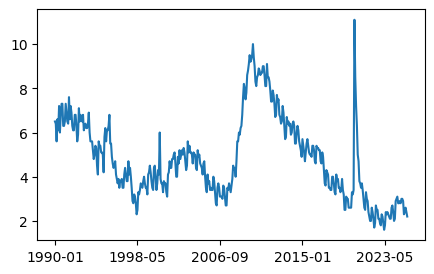

In [23]:
_ = df_labels.loc['geoId/01001'].plot(figsize=(5, 3))

#Data Visualization

## Download the county level geojson file.

The county level geojson file are available in the github repo under data folder. Download the geojson file into a local folder or a folder under Google drive. Here we assume that you have downloaded the file in Google Drive folder called pdfm_embeddings/v0/us

In [24]:
import geopandas as gpd

#@markdown Specify the path to the county geojson file.
county_geojson_file_path = '/content/drive/MyDrive/pdfm_embeddings/v0/us/county.geojson' #@param {type:"string"}
geo = gpd.read_file(county_geojson_file_path).set_index('place')
embeddings = gpd.GeoDataFrame(county_embeddings, geometry=geo.geometry)
embeddings.shape

(3088, 6)

## Map out an embedding dimension spatially.

In this example, we have mapped out feature0 dimension of the embeddings data for counties in New York.

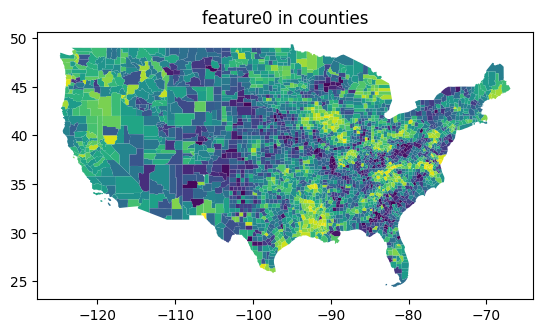

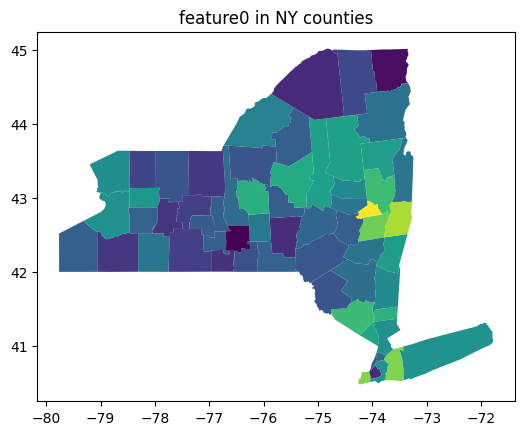

In [25]:
def get_locale(df, index, states=None, counties=None):
  df = df[df.index.isin(index)]
  if not states and not counties:
    return df
  filter = df.state.isin(states)
  if counties:
    filter &= df.county.isin(counties)
  return df[filter]

feature_name_to_plot = embedding_features[0]

# Extract the specific feature from the 'features' array column into a new column for plotting
feature_index = int(feature_name_to_plot.replace('feature', ''))
embeddings[feature_name_to_plot] = embeddings['features'].apply(lambda x: x[feature_index])

ax = get_locale(embeddings, county_embeddings.index).plot(feature_name_to_plot)
_ = ax.set_title(feature_name_to_plot + ' in counties')

ax = get_locale(embeddings, county_embeddings.index, states=['New York']).plot(feature_name_to_plot)
_ = ax.set_title(feature_name_to_plot + ' in NY counties')

# Applying the embeddings to a Nowcasting usecase.

Assume that we have unemployment data from 2024-07 from all counties, and only a subset of counties from 2024-08, we can predict the values for the rest of the counties using the embeddings.

We have demonstrated the Nowcasting example using a LightGBM (Light Gradient Boosting Machine) model.

In [29]:
def evaluate_model(y_true, y_pred):
    """Calculates Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)."""
    return {
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
    }

def train_and_evaluate(train_data, test_data, feature_sets, test_date, model_params=None):
    """
    Trains and evaluates models on given feature sets.

    Args:
    - train_data (pd.DataFrame): Training dataset with features and labels.
    - test_data (pd.DataFrame): Testing dataset with features and labels.
    - feature_sets (dict): Dictionary of feature set names and column lists.
    - test_date (str): Target date for prediction in test data.
    - model_params (dict, optional): Parameters for the LightGBM model.

    Returns:
    - pd.DataFrame: DataFrame with evaluation results for each feature set.
    """
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {
            'min_child_samples': 10,
            'num_leaves': 23,
            'max_bin': 100,
            'n_estimators': 100,
            'learning_rate': 0.1,
            'force_col_wise': True,
            'verbose': -1,
        }

    results = []
    # Drop rows with NaN in the test_date column for evaluation
    test_data_cleaned = test_data.dropna(subset=[test_date])

    for set_name, features in feature_sets.items():
        # Initialize and train the model
        model = lgbm.LGBMRegressor(**model_params)
        model.fit(train_data[features], train_data[test_date])

        # Make predictions and evaluate the model on the cleaned test_data
        predictions = model.predict(test_data_cleaned[features])
        eval_results = evaluate_model(test_data_cleaned[test_date], predictions)
        eval_results['Feature Set'] = set_name  # Add feature set name for reference
        results.append(eval_results)

    return pd.DataFrame(results)

In [32]:
#@title Training on 6 previous data points and embeddings
import lightgbm as lgbm
import numpy as np
from sklearn import linear_model
from sklearn import metrics

TEST_DATE = '2024-08'
TRAIN_START_DATE = '2024-02'
TRAIN_END_DATE = '2024-07'

train_dates = [x.strftime('%Y-%m') for x in pd.date_range(
    start=TRAIN_START_DATE, end=TRAIN_END_DATE, freq='MS')]

# Expand the 'features' list into separate columns for modeling
expanded_features_df = pd.DataFrame(county_embeddings['features'].tolist(), index=county_embeddings.index)
expanded_features_df.columns = embedding_features

# Join county_embeddings (without the original 'features' column) with the expanded features and then join with df_labels
data = county_embeddings.drop(columns=['features']).join(expanded_features_df).join(df_labels[train_dates + [TEST_DATE]])

train_data = data.sample(n=1000, random_state=42)
test_data = data.drop(train_data.index)
print(f"Training dates: {train_dates}")
print(f"Test date: {TEST_DATE}")
print(f"# Training counties: {train_data.shape[0]}")
print(f"# Test counties: {test_data.shape[0]}")

# Define feature sets for different model configurations
# 1. Using only past unemployment data
# 2. Using only embeddings data
# 3. Combining embeddings and past unemployment data to see additive improvements
FEATURE_SETS = {
    'Past Unemployment': train_dates,
    'Embeddings Only': embedding_features,
    'Embeddings + Past Unemployment': embedding_features + train_dates,
}

MODEL_PARAMS = {
    'min_child_samples': 10,
    'num_leaves': 23,
    'max_bin': 100,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'force_col_wise': True,
    'verbose': -1,
}

# Run training and evaluation for each feature set and display results
evaluation_results = train_and_evaluate(
    train_data=train_data,
    test_data=test_data,
    feature_sets=FEATURE_SETS,
    test_date=TEST_DATE,
    model_params=MODEL_PARAMS
)

print("Model Performance Results:")
evaluation_results.round(3)

Training dates: ['2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07']
Test date: 2024-08
# Training counties: 1000
# Test counties: 2088
Model Performance Results:


,MAE,MAPE,Feature Set
0,0.275,0.065,Past Unemployment
1,0.688,0.165,Embeddings Only
2,0.237,0.055,Embeddings + Past Unemployment


The results show that PDFM embeddings improve nowcasting accuracy when used in conjunction with past data.

In [33]:
#@title The improvements are bigger if there are fewer historical data points.
# Define new training configuration for limited historical data
MINHIST_TEST_DATE = '2024-08'
MINHIST_TRAIN_START_DATE = '2024-07'
MINHIST_TRAIN_END_DATE = '2024-07'

minhist_train_dates = [x.strftime('%Y-%m') for x in pd.date_range(
    start=MINHIST_TRAIN_START_DATE, end=MINHIST_TRAIN_END_DATE, freq='MS')]

# Expand the 'features' list into separate columns for modeling from the original county_embeddings
expanded_features_for_minhist_df = pd.DataFrame(county_embeddings['features'].tolist(), index=county_embeddings.index)
expanded_features_for_minhist_df.columns = embedding_features

# Combine county_embeddings (without the original 'features' column) with the expanded features and then join with df_labels
minhist_data = county_embeddings.drop(columns=['features']).join(expanded_features_for_minhist_df).join(df_labels[minhist_train_dates + [MINHIST_TEST_DATE]])

minhist_train_data = minhist_data.sample(n=1000, random_state=42)
minhist_test_data = minhist_data.drop(minhist_train_data.index)
print(f"Training dates with minimized history: {minhist_train_dates}")
print(f"Test date: {MINHIST_TEST_DATE}")
print(f"# Training counties: {minhist_train_data.shape[0]}")
print(f"# Test counties: {minhist_test_data.shape[0]}")

MINHIST_FEATURE_SETS = {
    'Past Unemployment (MinHist)': minhist_train_dates,
    'Embeddings Only': embedding_features,
    'Embeddings + Past Unemployment (MinHist)': embedding_features + minhist_train_dates,
}

minhist_results = train_and_evaluate(
    train_data=minhist_train_data,
    test_data=minhist_test_data,
    feature_sets=MINHIST_FEATURE_SETS,
    test_date=MINHIST_TEST_DATE,
    model_params=MODEL_PARAMS  # Reuse parameters from previous model configuration
)

print("Performance with Minimized Historical Data Points:")
minhist_results.round(3)

Training dates with minimized history: ['2024-07']
Test date: 2024-08
# Training counties: 1000
# Test counties: 2088
Performance with Minimized Historical Data Points:


,MAE,MAPE,Feature Set
0,0.292,0.069,Past Unemployment (MinHist)
1,0.688,0.165,Embeddings Only
2,0.265,0.062,Embeddings + Past Unemployment (MinHist)
